## Web Scraping: The San Francisco Chronicle

The code in this Jupyter notebook focuses on scraping text from [The San Francisco Chronicle](https://www.sfchronicle.com/) newspaper and then analyze the text.

## 1.1 Obtaining the links of all articles on a page

First we write a function that extracts all of the links to articles in a Chronicle article list. The function:

* Needs a parameter `url` for the URL of the article list.

* Return a list of article URLs (each URL should be a string).


In [10]:
import numpy as np
import pandas as pd
import lxml.html as lx
import requests
import requests_cache
import time
requests_cache.install_cache("mycache")


In [12]:
def get_article(url):
    '''This function takes the url of a section in San Francisco Chronicle and returns 
    all the url of the articles on the page'''
    response=requests.get(url)
    html=lx.fromstring(response.text)
    headline=html.xpath("//*[contains(@class,'headline')]")  #get class that contains 'headline'   
    headline_link=[i.xpath(".//a/@href")[0] for i in headline]
    rel=html.xpath("//div[contains(@class,'rel-links')]")    #get class that contains 'rel-links'
    rel_links=[i.xpath(".//a/@href")[0] for i in rel]
    total=rel_links+headline_link        #add them together  
    added=["https://www.sfchronicle.com"+i for i in total if str(i).startswith("/")==True] 
    #Only get the links starts with '/' because the ones starts with http are not relevant. 
    return list(set(added))
    

## 1.2 Obtain information for each article
Now we have the url for the articles, we may need a function that extracts data from a Chronicle article. The function should:

* Have a parameter `url` for the URL of the article.

* Return a dictionary with keys for:
    + `url`: The URL of the article.
    + `title`: The title of the article.
    + `text`: The complete text of the article.
    + `author`: The author's name (if available) or a suitable missing value.
    + `date`: The date and time the article was published.
    + `date_updated`: The date and time the article was last updated (if available) or a suitable missing value.



In [83]:
def get_info(url):
    '''This function takes the url to a single article and returns the author, title, text,date published and 
    date updated in a dictionary'''
    response=requests.get(url)
    html=lx.fromstring(response.text)
    
    #We use try&except in case of error
    #Get author and get rid of space and 'by'
    try:
        author=html.xpath("//*[@class='header-authors-name']|//*[contains(@class,'byline')]")[0].text_content()
        author=author.split(",")[0].replace("By"," ").strip().title()
        author=author.split('\n')
        author=" ".join([i.strip() for i in author])
    except:
        author=None
    
    #get title
    try:
        title=html.xpath("//*[contains(@class,'headline')]|//*[contains(@itemprop,'headline')]")[0].text_content()
    except:
        title=None
    
    #Get text
    p=html.xpath("//*[@class='article-body']/p|//*[@class='body']/p")
    text=[text.text_content() for text in p]
    text="\n\n".join(text)
    
    #Get date published
    try:
        date=html.xpath("//time[@itemprop='datePublished']/@datetime|//meta[contains(@itemprop,'datePublished')]/@content")[0]
        date=pd.to_datetime(date)
    except:
        date=None
    
    #get date updated if there is one
    try:    
        date_updated=html.xpath("//time[@itemprop='dateModified']/@datetime")[0]
        date_updated=pd.to_datetime(date_updated)
    except:
        date_updated=None        
    
    #Put them in a dictionary    
    d={"url":url,"author":author,"title":title,"text":text,"date":date,"date_updated":date_updated}
    return d

## 1.3 Formatting information into a data frame
I extracted the information of the articles in the `World`, `Business` and `Lifestyle` section in San Francisco Chronicle and format them into a data frame for convenience. 

In [36]:
business="https://www.sfchronicle.com/business/"
world="https://www.sfchronicle.com/us-world/"
lifestyle="https://www.sfchronicle.com/lifestyle/"

In order to obtain a date frame of information for all articles, `get_all_ArticleInfo` function is looped over all url for one page and put the returned dictionary in a list.

In [15]:
def get_all_ArticleInfo(url):
    '''Takes the url of a page in San Francisco Chronicle and returns a list of dictionaries.'''
    lists=[]
    all_links=get_article(url)
    for i in all_links:
        one=get_info(i)
        lists.append(one)
        time.sleep(2)
    return lists    

We get one data frame for each page and then organize them into one big data frame.

In [86]:
businesses=get_all_ArticleInfo(business)
df_business=pd.DataFrame(businesses)
df_business['Category']="Business"

In [69]:
worlds=get_all_ArticleInfo(world)
df_world=pd.DataFrame(worlds)
df_world['Category']="World&US"

In [18]:
lifestyles=get_all_ArticleInfo(lifestyle)
df_lifestyle=pd.DataFrame(lifestyles)
df_lifestyle['Category']="lifestyle"

In [115]:
big_df=[df_business,df_world,df_lifestyle]
big_df=pd.concat(big_df)
big_df

,author,date,date_updated,text,title,url,Category
0,Associated Press,2019-02-19 23:56:00,NaT,LONDON — Twitter said Tuesday that it is tight...,Twitter tightens up EU political ad rules ahea...,https://www.sfchronicle.com/business/article/T...,Business
1,Karen Weise,2019-02-20 23:52:32,NaT,A group of hackers associated with Russian int...,Microsoft says Russian hackers hit ahead of EU...,https://www.sfchronicle.com/business/article/M...,Business
2,Dominic Fracassa,2019-02-15 00:55:14,2019-02-15 00:56:10,"More than 250,000 San Francisco homes and busi...",CleanPowerSF tripling households served with m...,https://www.sfchronicle.com/bayarea/article/Cl...,Business
3,J.D. Morris,2019-02-13 00:02:44,2019-02-13 00:03:56,Jobs in California’s once-steadily growing sol...,California solar jobs fall for second year,https://www.sfchronicle.com/business/article/C...,Business
4,Carolyn Said,2018-02-16 14:00:00,NaT,"Under the threat of huge penalties, Airbnb, Ho...","SF short-term rentals transformed as Airbnb, o...",https://www.sfchronicle.com/business/article/S...,Business
5,Elaine Kurtenbach,2019-02-20 12:20:17,2019-02-20 12:23:13,BANGKOK (AP) — Stocks were mostly higher in Eu...,World shares mostly higher on upbeat talk on C...,https://www.sfchronicle.com/news/world/article...,Business
6,Brooks Barnes,2019-02-21 00:16:01,NaT,The film business has chewed up Amazon over th...,Amazon navigates Hollywood strife,https://www.sfchronicle.com/business/article/A...,Business
7,Carolyn Said,2018-02-16 14:00:00,2018-02-18 00:18:33,"If anyone knew the ropes about Airbnb rentals,...","Long, winding road to SF’s get-tough registrat...",https://www.sfchronicle.com/business/article/L...,Business
8,J.D. Morris,2019-02-19 12:00:00,2019-02-19 12:00:33,To meet its aggressive goals for fighting clim...,Can California homes and businesses quit natur...,https://www.sfchronicle.com/business/article/C...,Business
9,Elaine Kurtenbach,2019-02-19 04:04:10,2019-02-19 04:05:48,BANGKOK (AP) — Asian shares are mostly higher ...,Asian shares gain on hopes for progress on Chi...,https://www.sfchronicle.com/news/world/article...,Business


## 1.4 What's being covered recently? 
In this section, we will try to apply simple Natural Language Processing technique to the `text` part in the data frame obtained above to explore what has being covered recently in San Francisco Chronicle recently.

In [ ]:
texts=" ".join(df_lifestyle['text'])
stopwords=nltk.corpus.stopwords.words("english")

In [131]:
import nltk
import nltk.corpus
import re
%matplotlib inline
nltk.download("stopwords")
added_stopwords=["said","also","city","san","francisco","could","would","like","people","u","one","state","make","say","says","two","p","ha","wa"]
stopwords = nltk.corpus.stopwords.words("english")+added_stopwords
from nltk.stem import WordNetLemmatizer
wordnet_lematizer=WordNetLemmatizer()

AttributeError: module 'nltk' has no attribute 'data'

In [119]:
stopwords = corpus.stopwords.words("english")+added_stopwords


NameError: name 'corpus' is not defined

Some additional words that lack meaning on their own were added to the list of stopwords.In addition, the `get_freq` function below was written to pick the 'recent' articles(after 2019) and standardize the words in the text. 

In [206]:
def get_freq(df):
    '''This function takes the data frame for one page and returns the word frequency distributin and tri-grams for each page'''
    not_none=[i!=None for i in df['date']]                   #We filter out the articles without date to avoid error
    not_none=df.loc[not_none]
    
    recent=[float(i[:4])>=2019 for i in not_none['date']]    #Get the recent articles
    df_recent=not_none.loc[recent]
    one_string=" ".join(df_recent['text'])                   #Join the text for each article into one string
    one_string=re.split(r"[ ,.:;!?'\n\(\)]",one_string)      #tokenization
    one_string=[w.lower() for w in one_string]
    one_string=[wordnet_lematizer.lemmatize(w) for w in one_string]
    one_string=[w for w in one_string if w not in stopwords]
    one_string=[w for w in one_string if w.isalpha()==True]
    ngram=nltk.FreqDist(list(nltk.ngrams(one_string,3)))
    fq = nltk.FreqDist(w for w in one_string)
    ngram,fq=[ngram,fq]
    return ngram,fq

Method: first we are going to look at the frequency distribution plot of the first 20 most frequent words then take a look at the long words(>=15 letters) that only appeared once. We will also take a look at the tri-grams since the stand-alone words sometimes can't tell a good story.

## World & US

### Frequency distribution plot
*  The first 20 most frequent words in the recent news under World&US Section are shown in the frequency distribution plot.
*  By looking at some common words, the San Francisco Chronicle has been covering topics regarding: "smollett", "police", "trump", "venezuela".

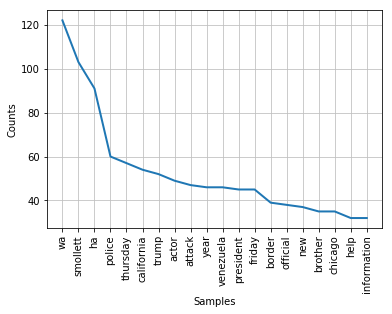

In [207]:
freq_world=get_freq(df_world)
get_freq(df_world)[1].plot(20)

### Long words that only appeared once
*  If we look at the long words that only appeared once, we can observe some words such as "conservatorship","denuclearization"," etc which are commonly seen in world news article.

In [208]:
once=freq_world[1].hapaxes()
words=[w for w in once if len(w)>=15]
words

['conservatorship',
 'confidentiality',
 'electrification',
 'environmentally',
 'otherwiseexceedingly',
 'philosophically',
 'denuclearization',
 'jamaicaglobalonline',
 'interuniversity']

### Top 20 Frequent tri-gram
*  By looking at the tri-gram we learned more about the recent topic covered by San Francisco Chronicle, such as Actor Jussie Smollet, felony disorderly conduct, president Donald Trump, racist, homophobic attack.

In [110]:
pd.DataFrame([" ".join(i[0]) for i in get_freq(df_world)[0].most_common(20)])

,0
0,actor jussie smollett
1,felony disorderly conduct
2,president nicolas maduro
3,hired two brothers
4,smollett surrendered thursday
5,two masked men
6,charge felony disorderly
7,president donald trump
8,superintendent eddie johnson
9,two brothers help


## Business

### Frequency distribution plot
*  The most frequent words in the recent news under Business Section are shown in the frequency distribution plot.
*  Some common word includes "percent","company","deduction","bankruptcy". However, with theses common words, it is difficult to tell what topics have been covered by San Francisco Chronicle recently.

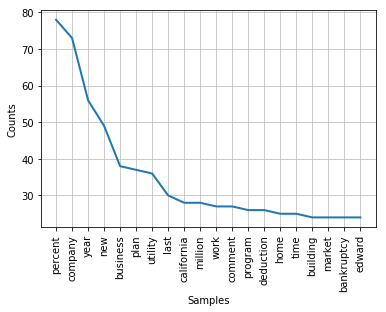

In [211]:
freq_business=get_freq(df_business)
freq_business[1].plot(20)

### Long words that only appeared once
*  If we look at the long words that only appeared once, we can observe that the words electrification, proprietorship, and the company name Scharffenberger, which are related to business. 

In [190]:
once=freq_business[1].hapaxes()
words=[w for w in once if len(w)>=15]
words

['electrification',
 'environmentally',
 'responsibilities',
 'telecommunications',
 'proprietorships',
 'scharffenberger']

### Top 20 Frequent tri-gram
*  By looking at the tri-gram we learned more about the recent topic covered by San Francisco Chronicle, such as "Public utilities commission","Merry edwards winery","PG&E","crude prices","trading".

In [112]:
pd.DataFrame([" ".join(i[0]) for i in get_freq(df_business)[0].most_common(20)])

,0
0,public utilities commission
1,merry edwards winery
2,pacific gas electric
3,gas electric co
4,department homeland security
5,california public utilities
6,brent crude used
7,crude used price
8,used price international
9,price international oils


## Lifestyle

### Frequency distribution plot
*  The most frequent words in the recent news under Lifestyle Section are shown in the frequency distribution plot.
*  Some common word includes "tahoe","valley","snow","park" which related to travelling.

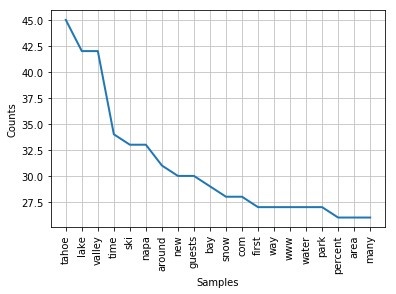

In [191]:
freq_life=get_freq(df_lifestyle)
freq_life[1].plot(20)

### Long words that only appeared once
*  If we look at the long words that only appeared once, we can observe that the words castellodiamarose,sterling vineyards(winery),marin county park(traveling) are highly related to lifestyle. 

In [192]:
once=freq_life[1].hapaxes()
words=[w for w in once if len(w)>=15]
words

['castellodiamarosa',
 'sterlingvineyards',
 'pinecrestnordic',
 'cabinsatstrawberry',
 'napavalleybiketours',
 'gondolaservizio',
 'activewineadventures',
 'experimentation',
 'unconstitutional',
 'landschaftspark',
 'bumblebeelovesyou',
 'marincountyparks']

### Top 20 Frequent tri-gram
*  By looking at the tri-gram we learned more about the recent topic covered by San Francisco Chronicle, such as "south lake tahoe","golden gate park","dodeg ridge ski","leland snow play","tasting per person"

In [118]:
pd.DataFrame([" ".join(i[0]) for i in get_freq(df_lifestyle)[0].most_common(20)])


,0
0,weekly travel newsletter
1,travel newsletter sign
2,south lake tahoe
3,stories check weekly
4,check weekly travel
5,stories check chronicle
6,check chronicle weekly
7,chronicle weekly travel
8,tom stienstra outdoors
9,stienstra outdoors writer


## Conclusion
*  Based on the above analysis we can have an educated guess of what topics are covered in the World, business and lifestyle sections recently. 

*  World& US section recently covers Actor Jussie Smollet, felony disorderly conduct, racist homophobic attack. Business section recently covers public utilities commisions, PG&E, crude oil price and trading. Lifestyle section recently covered travling(Tahoe lake,Golden Gate Park, Dodge Rideg Ski,leland snowplay) and wine tasting. 

*  Also we can see that category affects topics. For example, president Donald Trump/ was mentioned in both the world and business page but not(or rarely) mentioned in lifestyle section this might be because the lifestyle page tends to provide reders with smaller scale information(such as entertainment/traveling) rather than larger scale inforation(such as national news/business).   